# Import Libraries

In [1]:
import os
import re
import cv2
from tqdm import tqdm
import numpy as np
import pandas as pd
from IPython.display import Image, display

%matplotlib inline
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None  # default='warn'

import warnings
warnings.filterwarnings('ignore') 

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision
import PIL.ImageOps
from torch.autograd import Variable
from PIL import Image
from skimage.metrics import structural_similarity
from skimage.registration import phase_cross_correlation

In [2]:
class SiameseNetwork(nn.Module):
    """
    Siamese network for image similarity estimation.
    The network is composed of two identical networks, one for each input.
    The output of each network is concatenated and passed to a linear layer.
    The output of the linear layer passed through a sigmoid function.
    `"FaceNet" <https://arxiv.org/pdf/1503.03832.pdf>`_ is a variant of the Siamese network.
    This implementation varies from FaceNet as we use the `ResNet-18` model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_ as our feature extractor.
    In addition, we aren't using `TripletLoss` as the MNIST dataset is simple, so `BCELoss` can do the trick.
    """

    def __init__(self):
        super(SiameseNetwork, self).__init__()
        # get resnet model
        self.resnet = torchvision.models.resnet18(weights=None)

        # over-write the first conv layer to be able to read MNIST images
        # as resnet18 reads (3,x,x) where 3 is RGB channels
        # whereas MNIST has (1,x,x) where 1 is a gray-scale channel
        self.resnet.conv1 = nn.Conv2d(
            1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        )
        self.fc_in_features = self.resnet.fc.in_features

        # remove the last layer of resnet18 (linear layer which is before avgpool layer)
        self.resnet = torch.nn.Sequential(*(list(self.resnet.children())[:-1]))

        # add linear layers to compare between the features of the two images
        self.fc = nn.Sequential(
            nn.Linear(self.fc_in_features * 2, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 1),
        )

        self.sigmoid = nn.Sigmoid()

        # initialize the weights
        # self.resnet.apply(self.init_weights)
        self.fc.apply(self.init_weights)

    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)

    def forward_once(self, x):
        output = self.resnet(x)
        output = output.view(output.size()[0], -1)
        return output

    def forward(self, input1, input2):
        # get two images' features
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)

        # concatenate both images' features

        output = torch.cat((output1, output2), 1)

        # pass the concatenation to the linear layers
        output = self.fc(output)

        # pass the out of the linear layers to sigmoid layer
        output = self.sigmoid(output)

        return output

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SiameseNetwork().to(device)
model.load_state_dict(torch.load("../siamese/content/model_BCE.pth"))
model.eval()

SiameseNetwork(
  (resnet): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats

In [4]:
def computer_sim_score(img1_path, img2_path):
    imgRef = cv2.imread(img1_path)
    imgTest = cv2.imread(img2_path)
    # Convert to grayscale.
    imgTest_grey = cv2.cvtColor(imgTest, cv2.COLOR_BGR2GRAY)
    imgRef_grey = cv2.cvtColor(imgRef, cv2.COLOR_BGR2GRAY)

    height1, width1 = imgRef_grey.shape
    height2, width2 = imgTest_grey.shape

    height_max = max(height1, height2)
    width_max = max(width1, width2)

    # Pad the images to same size
    imgRef_grey = cv2.copyMakeBorder(
        imgRef_grey,
        height_max - height1,
        0,
        width_max - width1,
        0,
        cv2.BORDER_REPLICATE,
    )
    imgTest_grey = cv2.copyMakeBorder(
        imgTest_grey,
        height_max - height2,
        0,
        width_max - width2,
        0,
        cv2.BORDER_REPLICATE,
    )

    # pixel precision first
    shift, _, _ = phase_cross_correlation(imgRef_grey, imgTest_grey)
    # print(f"Detected subpixel offset (y, x): {shift}")

    height_offset, weith_offset = int(shift[0]), int(shift[1])

    # Compute Similarity
    if height_offset > 0 and weith_offset > 0:
        imgRef_grey = imgRef_grey[height_offset:, weith_offset:]
        imgTest_grey = imgTest_grey[:-height_offset, :-weith_offset]

    elif height_offset > 0 and weith_offset < 0:
        imgRef_grey = imgRef_grey[height_offset:, :weith_offset]
        imgTest_grey = imgTest_grey[:-height_offset, -weith_offset:]

    elif height_offset < 0 and weith_offset > 0:
        imgRef_grey = imgRef_grey[:height_offset, weith_offset:]
        imgTest_grey = imgTest_grey[-height_offset:, :-weith_offset]

    elif height_offset < 0 and weith_offset < 0:
        imgRef_grey = imgRef_grey[:height_offset, :weith_offset]
        imgTest_grey = imgTest_grey[-height_offset:, -weith_offset:]

    elif height_offset == 0 and weith_offset > 0:
        imgRef_grey = imgRef_grey[:, weith_offset:]
        imgTest_grey = imgTest_grey[:, :-weith_offset]

    elif height_offset == 0 and weith_offset < 0:
        imgRef_grey = imgRef_grey[:, :weith_offset]
        imgTest_grey = imgTest_grey[:, -weith_offset:]

    elif height_offset > 0 and weith_offset == 0:
        imgRef_grey = imgRef_grey[height_offset:, :]
        imgTest_grey = imgTest_grey[:-height_offset, :]

    elif height_offset < 0 and weith_offset == 0:
        imgRef_grey = imgRef_grey[:height_offset, :]
        imgTest_grey = imgTest_grey[-height_offset:, :]

    elif height_offset == 0 and weith_offset == 0:
        imgRef_grey = imgRef_grey
        imgTest_grey = imgTest_grey

    (score, diff) = structural_similarity(
        imgRef_grey,
        imgTest_grey,
        full=True,
    )

    return score

In [5]:
transform = transforms.Compose([transforms.Resize((105, 105)), transforms.ToTensor()])


def transformation(transform, image1_path):
    img = Image.open(image1_path)
    img = img.convert("L")

    # Apply image transformations
    img = transform(img)
    return img


def register(img1_path, img2_path):
    imgRef = cv2.imread(img1_path)
    imgTest = cv2.imread(img2_path)
    # Convert to grayscale.
    imgTest_grey = cv2.cvtColor(imgTest, cv2.COLOR_BGR2GRAY)
    imgRef_grey = cv2.cvtColor(imgRef, cv2.COLOR_BGR2GRAY)

    height1, width1 = imgRef_grey.shape
    height2, width2 = imgTest_grey.shape

    height_max = max(height1, height2)
    width_max = max(width1, width2)

    # Pad the images to same size
    imgRef_grey = cv2.copyMakeBorder(
        imgRef_grey,
        height_max - height1,
        0,
        width_max - width1,
        0,
        cv2.BORDER_REPLICATE,
    )
    imgTest_grey = cv2.copyMakeBorder(
        imgTest_grey,
        height_max - height2,
        0,
        width_max - width2,
        0,
        cv2.BORDER_REPLICATE,
    )

    # pixel precision first
    shift, _, _ = phase_cross_correlation(imgRef_grey, imgTest_grey)
    # print(f"Detected subpixel offset (y, x): {shift}")

    height_offset, weith_offset = int(shift[0]), int(shift[1])

    # Compute Similarity
    if height_offset > 0 and weith_offset > 0:
        imgRef_grey = imgRef_grey[height_offset:, weith_offset:]
        imgTest_grey = imgTest_grey[:-height_offset, :-weith_offset]

    elif height_offset > 0 and weith_offset < 0:
        imgRef_grey = imgRef_grey[height_offset:, :weith_offset]
        imgTest_grey = imgTest_grey[:-height_offset, -weith_offset:]

    elif height_offset < 0 and weith_offset > 0:
        imgRef_grey = imgRef_grey[:height_offset, weith_offset:]
        imgTest_grey = imgTest_grey[-height_offset:, :-weith_offset]

    elif height_offset < 0 and weith_offset < 0:
        imgRef_grey = imgRef_grey[:height_offset, :weith_offset]
        imgTest_grey = imgTest_grey[-height_offset:, -weith_offset:]

    elif height_offset == 0 and weith_offset > 0:
        imgRef_grey = imgRef_grey[:, weith_offset:]
        imgTest_grey = imgTest_grey[:, :-weith_offset]

    elif height_offset == 0 and weith_offset < 0:
        imgRef_grey = imgRef_grey[:, :weith_offset]
        imgTest_grey = imgTest_grey[:, -weith_offset:]

    elif height_offset > 0 and weith_offset == 0:
        imgRef_grey = imgRef_grey[height_offset:, :]
        imgTest_grey = imgTest_grey[:-height_offset, :]

    elif height_offset < 0 and weith_offset == 0:
        imgRef_grey = imgRef_grey[:height_offset, :]
        imgTest_grey = imgTest_grey[-height_offset:, :]

    elif height_offset == 0 and weith_offset == 0:
        imgRef_grey = imgRef_grey
        imgTest_grey = imgTest_grey

    imgRef_grey = transform(Image.fromarray(imgRef_grey).convert("L"))
    imgTest_grey = transform(Image.fromarray(imgTest_grey).convert("L"))

    return imgRef_grey.to(device), imgTest_grey.to(device)

# Read Features

In [6]:
df = pd.read_csv("/fs9/yuxiao/nii_project/dataset/df/feature_data_2.csv")

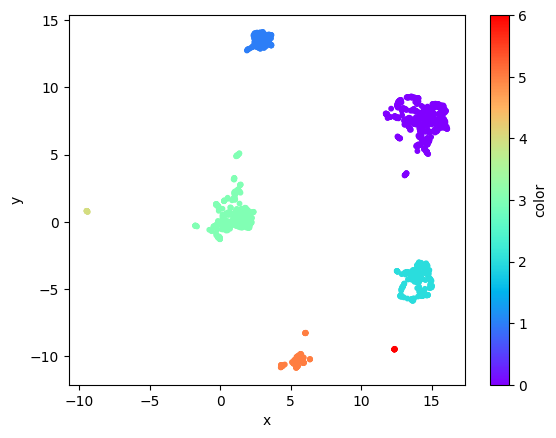

In [7]:
char = "の"
color_dict = {}
for idx, element in enumerate(np.unique(df.loc[df["char"] == char].label)):
    color_dict[element] = idx
df["color"] = df.loc[df["char"] == char, "label"].map(color_dict)

ax = df.plot.scatter(x="x", y="y", s=10, c="color", cmap="rainbow")
plt.show()

In [8]:
label_list = np.unique(df.label)

In [11]:
df["block"] = np.nan
for i in tqdm(range(len(label_list))):
    count = 0
    char = re.sub("[\W\d_]+", "", label_list[i])
    for idx1, row1 in df.loc[df["label"] == label_list[i]].iterrows():
        if np.isnan(df.loc[idx1, "block"]):
            count += 1
            df.loc[idx1, "block"] = count
            img1 = transformation(transform, "../dataset/1/" + row1.image_file).to(
                device
            )
            directory = f"../dataset/char_block_4/{char}/{label_list[i]}/{count}"
            if not os.path.exists(directory):
                os.makedirs(directory)
            Image.open(f"../dataset/1/{row1.image_file}").save(
                f"{directory}/{row1.image_file}"
            )
            for idx2, row2 in df.loc[df["label"] == label_list[i]].iterrows():
                if np.isnan(df.loc[idx2, "block"]):
                    img2 = transformation(
                        transform, "../dataset/1/" + row2.image_file
                    ).to(device)
                    # img1, img2 = register(
                    #     "../dataset/2/" + row1.image_file,
                    #     "../dataset/2/" + row2.image_file,
                    # )
                    output = model(img1.unsqueeze(0), img2.unsqueeze(0))
                    sim_score = computer_sim_score(
                        "../dataset/1/" + row1.image_file,
                        "../dataset/1/" + row2.image_file,
                    )
                    if output < 0.5:
                        df.loc[idx2, "block"] = count
                        Image.open(f"../dataset/1/{row2.image_file}").save(
                            f"{directory}/{row2.image_file}"
                        )
    if i == 10:
        break

  0%|          | 10/4598 [00:02<19:51,  3.85it/s]


In [72]:
img1 = transformation(
    transform, "/fs9/yuxiao/nii_project/dataset/char_block_3/あ/あ_1/2/22253_001_39_1.jpg"
).to(device)
img2 = transformation(
    transform, "/fs9/yuxiao/nii_project/dataset/char_block_3/あ/あ_1/2/3548_001_115_0.jpg"
).to(device)

img1, img2 = register(
    "/fs9/yuxiao/nii_project/dataset/char_block_3/あ/あ_1/2/22253_001_39_1.jpg",
    "/fs9/yuxiao/nii_project/dataset/char_block_3/あ/あ_1/2/3548_001_115_0.jpg",
)
o1, o2 = model(img1.unsqueeze(0), img2.unsqueeze(0))
euclidean_distance = F.pairwise_distance(o1, o2)
euclidean_distance

tensor([2.5087], device='cuda:0', grad_fn=<NormBackward1>)

In [36]:
df.loc[df["label"] == "子_0"].groupby("block").size().sort_values()

block
5.0    1
6.0    1
7.0    1
8.0    1
9.0    1
4.0    2
1.0    4
3.0    5
2.0    9
dtype: int64

In [47]:
from IPython.display import Image, display

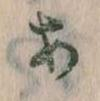

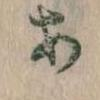

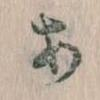

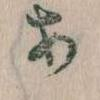

In [55]:
for url in df.loc[df["block"] == 7].image_file:
    display(Image(filename="../dataset/1/" + url))